## <span style = "color: #9fcddfff;"> **Data Load & Preprocessing** </span>

Conv2D → produces activations

BatchNorm → normalizes those conv activations

MaxPooling → downsamples normalized features

Flatten → prepares for dense layers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D, Conv2D
import keras_tuner as kt
import tensorflow as tf

import time
start_time = time.time()

In [2]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

#Load data in
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

#Seperating the Features from the Labels
x = np.concatenate((train_images, test_images), axis=0)
y = np.concatenate((train_labels, test_labels), axis=0)

#Confirming Data Structure
print('The feature data shape is:', x.shape)
print('The labels data shape is:', y.shape)

#Confirming the data structures of the split data
print('\nThe training feature shape is:', train_images.shape)
print('The test feature shape is:', test_images.shape)
print('\nThe training labels shape is:', train_labels.shape)
print('The test labels shape is:', test_labels.shape)

The feature data shape is: (60000, 32, 32, 3)
The labels data shape is: (60000, 1)

The training feature shape is: (50000, 32, 32, 3)
The test feature shape is: (10000, 32, 32, 3)

The training labels shape is: (50000, 1)
The test labels shape is: (10000, 1)


In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = 10


y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

In [4]:
# Reshape the data

x_train = train_images.astype('float32') / 255.0
x_test = test_images.astype('float32') / 255.0

#Scale 
reshape =  32*32*3

x_train = x_train.reshape((x_train.shape[0], reshape))
x_test = x_test.reshape((x_test.shape[0], reshape))

print('\nThe reshaped training feature shape is:', x_train.shape)
print('The reshaped test feature shape is:', x_test.shape)


The reshaped training feature shape is: (50000, 3072)
The reshaped test feature shape is: (10000, 3072)


In [5]:
# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('The updated training data shape is:', x_train.shape)
print('The validation data shape is:', x_val.shape)

x_val = x_val.astype('float32') / 255.0


The updated training data shape is: (40000, 3072)
The validation data shape is: (10000, 3072)


### <span style = "color: #9fcddfff;"> **Data Exploration** </span>

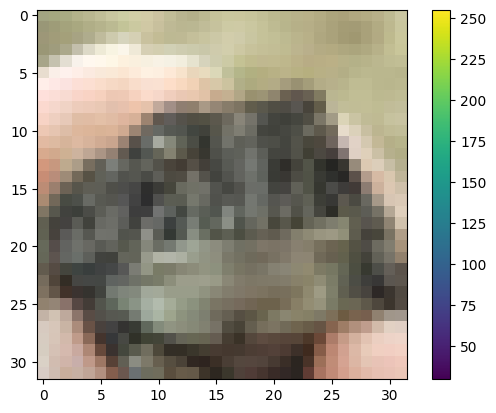

In [6]:
plt.figure()
# x_train was reshaped to (N, 3072). Use the unflattened array x_train_full (shape (N,32,32,3))
plt.imshow(train_images[25])
plt.colorbar()
plt.grid(False)
plt.show()

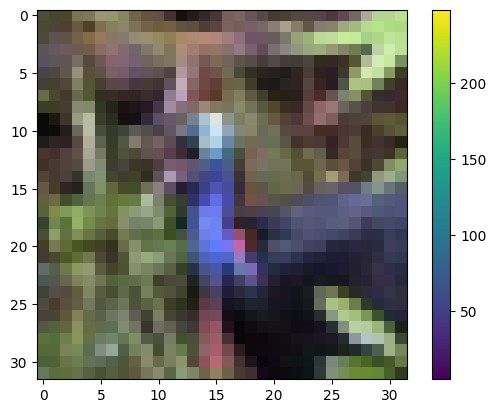

In [7]:
plt.figure()
# x_train was reshaped to (N, 3072). Use the unflattened array x_train_full (shape (N,32,32,3))
plt.imshow(train_images[24])
plt.colorbar()
plt.grid(False)
plt.show()

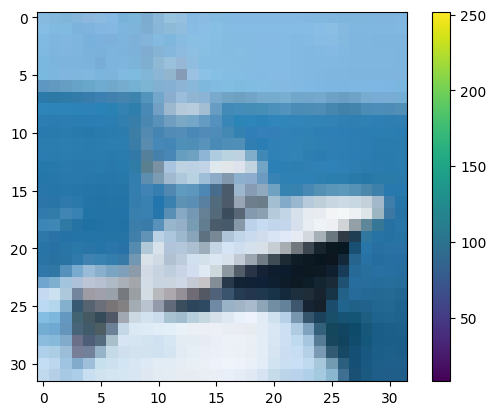

In [8]:
plt.figure()
plt.imshow(train_images[8])
plt.colorbar()
plt.grid(False)
plt.show()

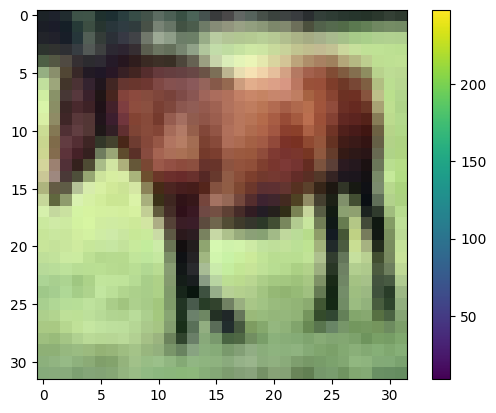

In [9]:
plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

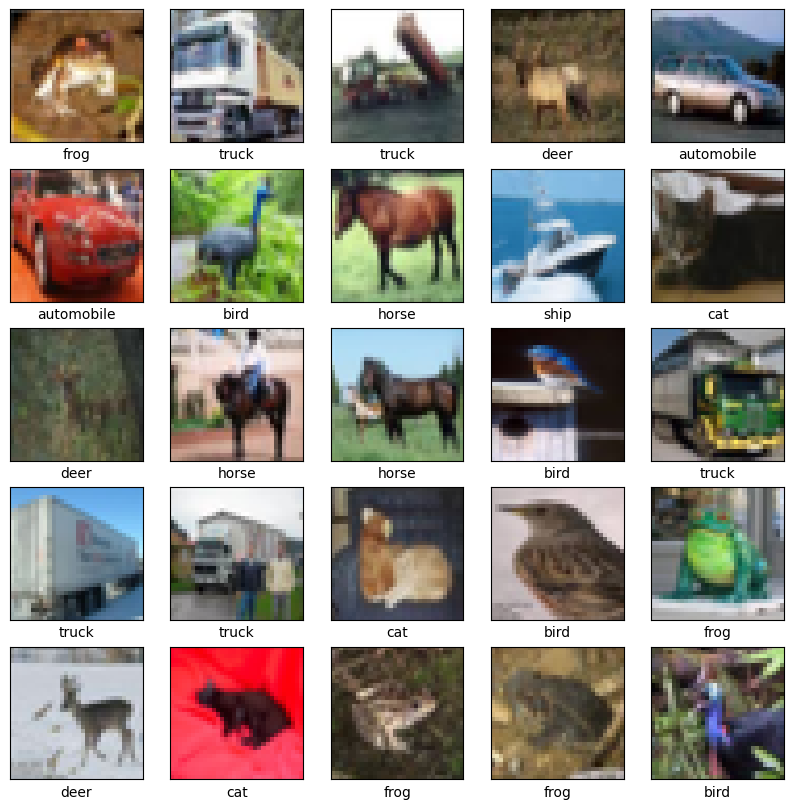

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # train_labels has shape (N,1) so extract the scalar and cast to int for indexing
    plt.xlabel(classes[int(train_labels[i, 0])])
plt.show()

## <span style = "color: #9fcddfff;"> **Model Developments** </span>

### <span style = "color: #9fcddfff;"> **Experiment 1: FeedForward Model with KerasTuner** </span>

In [ ]:
#Global droppout tuning for baseline model

def build_ffnn_model(hp):
    #To debug tghe issues with hyperparameters
    print("HP values:", hp.values)

    model= Sequential()

    #Global decision on dropout use or not
    use_dropout = hp.Boolean('use_dropout', default=False)

    #Input layer
    model.add(Dense(
        units=hp.Int('input_units', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(reshape,)
    ))

    #Hidden Layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=2)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        ))

        if use_dropout:
            dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
            model.add(Dropout(rate=dropout_rate))
    
    #Output Layer
    model.add(Dense(num_classes, activation='softmax'))


    #Optimizer tuning
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice =='adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        momentum = hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    #Model Compilation
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
import shutil
shutil.rmtree('my_tuning', ignore_errors=True)
shutil.rmtree('my_dir', ignore_errors=True)

In [ ]:
# Initialize Model

tuner = kt.Hyperband(
    build_ffnn_model, 
    objective= 'val_accuracy',
    max_epochs=5,
    #factor=3,
    directory='my_tuning',
    project_name='ffnn_experiment',
    overwrite=True
)

HP values: {}


c:\Users\kojus\anaconda3\envs\ML_DM\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Tuner searches for best hyperparameters

tuner.search(
    x_train, y_train,
    epochs=6,  
    validation_data=(x_val, y_val)
    #,batch_size=64                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
)

Trial 30 Complete [00h 18m 38s]
val_accuracy: 0.12700000405311584

Best val_accuracy So Far: 0.13109999895095825
Total elapsed time: 02h 34m 33s


In [15]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"Number of layers: {best_hp.get('num_layers')}")
print(f"Use dropout: {best_hp.get('use_dropout')}")
print(f"Optimizer: {best_hp.get('optimizer')}")
print(f"Learning rate: {best_hp.get('lr')}")

# Print layer-specific parameters
for i in range(best_hp.get('num_layers')):
    print(f"Layer {i+1}: {best_hp.get(f'units_{i}')} units, {best_hp.get(f'activation_{i}')} activation")
    if best_hp.get('use_dropout'):
        print(f"  Dropout rate: {best_hp.get(f'dropout_{i}')}")

# Get the best trial results
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"\nBest validation accuracy: {best_trial.score}")
print(f"Best trial ID: {best_trial.trial_id}")

Number of layers: 1
Use dropout: False
Optimizer: rmsprop
Learning rate: 0.004170004462263622
Layer 1: 64 units, tanh activation

Best validation accuracy: 0.13109999895095825
Best trial ID: 0009


In [16]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS & TRAINING RESULTS")
print("="*60)

# Hyperparameters summary
print(f"\n📍 BEST CONFIGURATION")
print(f"   • Hidden Layers: {best_hp.get('num_layers')}")
print(f"   • Optimizer: {best_hp.get('optimizer')} (lr: {best_hp.get('lr'):.6f})")
print(f"   • Dropout: {best_hp.get('use_dropout')}")

# Architecture details
print(f"\n🏗️  ARCHITECTURE")
print(f"   • Input: {best_hp.get('input_units')} units")
for i in range(best_hp.get('num_layers')):
    layer_desc = f"   • Layer {i+1}: {best_hp.get(f'units_{i}')} units ({best_hp.get(f'activation_{i}')})"
    if best_hp.get('use_dropout'):
        layer_desc += f" + dropout({best_hp.get(f'dropout_{i}')})"
    print(layer_desc)

# Results
print(f"\n🏆 RESULTS")
print(f"   • Best Validation Accuracy: {best_trial.score:.4f}")
print(f"   • Trial ID: {best_trial.trial_id}")

# Quick training to get current metrics
print(f"\n📊 CURRENT PERFORMANCE")
try:
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Evaluate on validation set
    val_loss, val_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
    train_loss, train_accuracy = best_model.evaluate(x_train, y_train, verbose=0)
    
    print(f"   • Training Loss:     {train_loss:.4f}")
    print(f"   • Training Accuracy: {train_accuracy:.4f}")
    print(f"   • Validation Loss:   {val_loss:.4f}")
    print(f"   • Validation Accuracy: {val_accuracy:.4f}")
    
    # Performance gaps
    print(f"\n📈 PERFORMANCE GAPS")
    print(f"   • Loss Difference:     {val_loss - train_loss:+.4f}")
    print(f"   • Accuracy Difference: {train_accuracy - val_accuracy:+.4f}")
    
except Exception as e:
    print(f"   • Could not evaluate model: {e}")

print("="*60)


BEST HYPERPARAMETERS & TRAINING RESULTS

📍 BEST CONFIGURATION
   • Hidden Layers: 1
   • Optimizer: rmsprop (lr: 0.004170)
   • Dropout: False

🏗️  ARCHITECTURE
   • Input: 512 units
   • Layer 1: 64 units (tanh)

🏆 RESULTS
   • Best Validation Accuracy: 0.1311
   • Trial ID: 0009

📊 CURRENT PERFORMANCE
HP values: {'use_dropout': False, 'input_units': 512, 'num_layers': 1, 'units_0': 64, 'activation_0': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.004170004462263622, 'dropout_0': 0.2, 'momentum': 0.6000000000000001, 'units_1': 64, 'activation_1': 'relu', 'units_2': 192, 'activation_2': 'tanh', 'dropout_1': 0.4, 'dropout_2': 0.30000000000000004, 'units_3': 320, 'activation_3': 'relu', 'dropout_3': 0.4, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
   • Training Loss:     2.3415
   • Training Accuracy: 0.0996
   • Validation Loss:   2.3055
   • Validation Accuracy: 0.1311

📈 PERFORMANCE GAPS
   • Loss Difference:     -0.0360
   • Accuracy Difference: -0.0

In [ ]:
def build_ff_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(3072,)))
    
    # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu'))
    
    model.add(Dense(10, activation='softmax'))
    
    optimizer = ['SGD', 'RMSprop', 'Adam']
    hp.Choice('optimizer', values=optimizer)
    model.compile(
        optimizer=hp.get('optimizer'),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner_ff = kt.Hyperband(
    build_ff_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name='cifar10_ff_tuning'
)   

tuner_ff.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
best_ff_model = tuner_ff.get_best_models(num_models=1)[0]
best_ff_hyperparameters = tuner_ff.get_best_hyperparameters(num_trials=1)[0]
best_ff_model.summary()
best_ff_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
test_ff_loss, test_ff_acc = best_ff_model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_ff_acc)

Trial 8 Complete [00h 01m 15s]
val_accuracy: 0.09960000216960907

Best val_accuracy So Far: 0.12439999729394913
Total elapsed time: 00h 10m 40s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
2                 |1                 |num_layers
256               |512               |units_0
Adam              |Adam              |optimizer
320               |320               |units_1
64                |32                |units_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.3173 - loss: 1.8819 - val_accuracy: 0.0996 - val_loss: 2.3214
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3857 - loss: 1.7179

KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS & TRAINING RESULTS")
print("="*60)

# Hyperparameters summary
print(f"\n📍 BEST CONFIGURATION")
print(f"   • Hidden Layers: {best_hp.get('num_layers')}")
print(f"   • Optimizer: {best_hp.get('optimizer')} (lr: {best_hp.get('lr'):.6f})")
print(f"   • Dropout: {best_hp.get('use_dropout')}")

# Architecture details
print(f"\n🏗️  ARCHITECTURE")
print(f"   • Input: {best_hp.get('input_units')} units")
for i in range(best_hp.get('num_layers')):
    layer_desc = f"   • Layer {i+1}: {best_hp.get(f'units_{i}')} units ({best_hp.get(f'activation_{i}')})"
    if best_hp.get('use_dropout'):
        layer_desc += f" + dropout({best_hp.get(f'dropout_{i}')})"
    print(layer_desc)

# Results
print(f"\n🏆 RESULTS")
print(f"   • Best Validation Accuracy: {best_trial.score:.4f}")
print(f"   • Trial ID: {best_trial.trial_id}")

# Quick training to get current metrics
print(f"\n📊 CURRENT PERFORMANCE")
try:
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Evaluate on validation set
    val_loss, val_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
    train_loss, train_accuracy = best_model.evaluate(x_train, y_train, verbose=0)
    
    print(f"   • Training Loss:     {train_loss:.4f}")
    print(f"   • Training Accuracy: {train_accuracy:.4f}")
    print(f"   • Validation Loss:   {val_loss:.4f}")
    print(f"   • Validation Accuracy: {val_accuracy:.4f}")
    
    # Performance gaps
    print(f"\n📈 PERFORMANCE GAPS")
    print(f"   • Loss Difference:     {val_loss - train_loss:+.4f}")
    print(f"   • Accuracy Difference: {train_accuracy - val_accuracy:+.4f}")
    
except Exception as e:
    print(f"   • Could not evaluate model: {e}")

print("="*60)

----

### <span style = "color: #9fcddfff;"> **Experiment 2: CNN Model with KerasTuner** </span>

In [ ]:
def build_cnn_model(hp):

    cnn_model = Sequential()


    #Global Decision: number of blocks
    num_blocks = hp.Int('num_blocks', 1, 2)

    #Global Decision: BatchNormalization
    use_batchnorm = hp.Boolean('use_batchnorm', default=False)

    #first block
    cnn_model.add(Conv2D(
        filters=hp.Int('block1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Int('block1_kernel', min_value=3, max_value=5, step=2),
        activation='relu',
        padding = 'same',
        input_shape=(3, 32, 32)
    ))

        #Optional BatchNormalization
        if use_batchnorm:
            cnn_model.add(BatchNormalization())
    
        #Optional maxpooling
        if hp.Boolean('block1_maxpool', default=False):
            cnn_model.add(MaxPooling2D(pool_size=(2,2)))
            #cnn_model.add(Dropout(rate=hp.Float('block1_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    cnn_model.add(Flatten())

    #additional blocks
    for i in range(2, num_blocks + 1):
        cnn_model.add(Conv2D(
            filters= hp.Int(f'block_{i}_filters', min_value=64, max_value=512, step=64),
            kernel_size = hp.Int(f'block_{i}_kernel', min_value=3, max_value=5, step=2),
            activation='relu',
            padding='same'  
        ))

        #Optional BatchNormalization
        if use_batchnorm andf hp.Boolean('bn-after_dense', default=False):
            cnn_model.add(BatchNormalization())

        #Optional maxpooling
        if hp.Boolean(f'block{i}_maxpooling', default=False):
            cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    #Flatten is necessarey and not debattable before Dense layer
    cnn_model.add(Flatten())

    #Optional Dense Layers
    dense = hp.Int('dense', 0, 3)
    for value in range (dense):
        cnn_model.add(Dense(
            units=hp.Int(f'units_{value}', min_value=64, max_value=512, step=64),
            activation='relu',
        ))

    #Output Layer
    cnn_model.add(Dense(num_classes, activation='softmax'))


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]


print("BEST HYPERPARAMETERS & TRAINING RESULTS")

# Hyperparameters summary - UPDATED FOR CNN

print(f"  • Conv Blocks: {best_hp.get('num_blocks')}")
print(f"  • Optimizer: {best_hp.get('optimizer')} (lr: {best_hp.get('learning_rate', best_hp.get('lr', 0.001)):.6f})")  # Handle both 'lr' and 'learning_rate'
print(f"  • Batch Normalization: {best_hp.get('use_batchnorm', False)}")
print(f"  • Dense Layers: {best_hp.get('num_dense_layers', best_hp.get('num_dense', 0))}")  # Handle different naming

# Architecture details - UPDATED FOR CNN
print(f"\n🏗️  ARCHITECTURE")

# Conv blocks details
for i in range(best_hp.get('num_blocks', 1)):
    filters = best_hp.get(f'block_{i}_filters', best_hp.get(f'block{i}_filter'))  # Handle naming variations
    kernel = best_hp.get(f'block_{i}_kernel', best_hp.get(f'block{i}_kernel'))
    pool = best_hp.get(f'block_{i}_pool', best_hp.get(f'block{i}_maxpool', False))
    
    block_desc = f"   • Conv Block {i+1}: {filters} filters, kernel={kernel}"
    if pool:
        block_desc += " + MaxPooling"
    if best_hp.get('use_batchnorm', False):
        block_desc += " + BatchNorm"
    print(block_desc)

# Dense layers details
num_dense = best_hp.get('num_dense_layers', best_hp.get('num_dense', 0))
print(f"   • Flatten → ", end="")
if num_dense > 0:
    for i in range(num_dense):
        units = best_hp.get(f'dense_units_{i}', best_hp.get(f'dense_{i}_units'))
        print(f"Dense({units}) → ", end="")
    print("Output(10)")
else:
    print("Output(10)")  # No dense layers

# Results - THIS PART STAYS THE SAME
print(f"\n🏆 RESULTS")
print(f"   • Best Validation Accuracy: {best_trial.score:.4f}")
print(f"   • Trial ID: {best_trial.trial_id}")

# Quick training to get current metrics - THIS PART STAYS THE SAME
print(f"\n📊 CURRENT PERFORMANCE")
try:
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Evaluate on validation set
    val_loss, val_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
    train_loss, train_accuracy = best_model.evaluate(x_train, y_train, verbose=0)
    
    print(f"   • Training Loss:     {train_loss:.4f}")
    print(f"   • Training Accuracy: {train_accuracy:.4f}")
    print(f"   • Validation Loss:   {val_loss:.4f}")
    print(f"   • Validation Accuracy: {val_accuracy:.4f}")
    
    # Performance gaps
    print(f"\n📈 PERFORMANCE GAPS")
    print(f"   • Loss Difference:     {val_loss - train_loss:+.4f}")
    print(f"   • Accuracy Difference: {train_accuracy - val_accuracy:+.4f}")
    
except Exception as e:
    print(f"   • Could not evaluate model: {e}")

print("="*60)

In [ ]:
def print_tuning_results(tuner, x_train, y_train, x_val, y_val):
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    print("\n" + "="*60)
    print("BEST HYPERPARAMETERS & TRAINING RESULTS")
    print("="*60)
    
    # Smart detection of model type
    has_conv = any('block' in key and 'filter' in key for key in best_hp.values.keys())
    model_type = "CNN" if has_conv else "FFNN"
    
    print(f"\n📍 BEST {model_type} CONFIGURATION")
    
    # Common hyperparameters
    if 'optimizer' in best_hp.values:
        lr = best_hp.get('learning_rate', best_hp.get('lr', 0.001))
        print(f"   • Optimizer: {best_hp.get('optimizer')} (lr: {lr:.6f})")
    
    # Architecture-specific details
    if model_type == "CNN":
        print(f"   • Conv Blocks: {best_hp.get('num_blocks', 1)}")
        print(f"   • BatchNorm: {best_hp.get('use_batchnorm', False)}")
        
        print(f"\n🏗️  CNN ARCHITECTURE")
        for i in range(best_hp.get('num_blocks', 1)):
            filters = best_hp.get(f'block_{i}_filters', best_hp.get(f'block{i}_filter', 'N/A'))
            kernel = best_hp.get(f'block_{i}_kernel', best_hp.get(f'block{i}_kernel', 'N/A'))
            print(f"   • Block {i+1}: {filters} filters, kernel={kernel}")
            
    else:  # FFNN
        print(f"   • Hidden Layers: {best_hp.get('num_layers', 1)}")
        print(f"   • Dropout: {best_hp.get('use_dropout', False)}")
        
        print(f"\n🏗️  FFNN ARCHITECTURE")
        print(f"   • Input: {best_hp.get('input_units', 'N/A')} units")
        for i in range(best_hp.get('num_layers', 0)):
            units = best_hp.get(f'units_{i}', best_hp.get(f'hidden_units_{i}', 'N/A'))
            activation = best_hp.get(f'act_{i}', best_hp.get(f'activation_{i}', 'relu'))
            print(f"   • Layer {i+1}: {units} units ({activation})")
    
    # Results (same for both)
    print(f"\n🏆 RESULTS")
    print(f"   • Best Validation Accuracy: {best_trial.score:.4f}")
    
    # Evaluation
    print(f"\n📊 CURRENT PERFORMANCE")
    try:
        best_model = tuner.get_best_models(num_models=1)[0]
        val_loss, val_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
        train_loss, train_accuracy = best_model.evaluate(x_train, y_train, verbose=0)
        
        print(f"   • Training Accuracy: {train_accuracy:.4f}")
        print(f"   • Validation Accuracy: {val_accuracy:.4f}")
        print(f"   • Overfitting Gap: {train_accuracy - val_accuracy:+.4f}")
        
    except Exception as e:
        print(f"   • Evaluation error: {e}")
    
    print("="*60)

# Usage for both FFNN and CNN:
print_tuning_results(tuner, x_train, y_train, x_val, y_val)

### <span style = "color: #9fcddfff;"> **Experiment 1** </span>

### <span style = "color: #9fcddfff;"> **Experiment 2** </span>

### <span style = "color: #9fcddfff;"> **Experiment 3** </span>

### <span style = "color: #9fcddfff;"> **Experiment 4** </span>